Буду использовать сеть U-Net, которая является стандартной архитектурой для задач сегментации изображений. Производственный датасет - СЕВЕРСТАЛЬ из 4 семинара

Часть 1: Импорт и предварительная обработка данных

In [1]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Игнорировать предупреждения
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from multiprocessing.pool import ThreadPool
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation
from keras.metrics import MeanIoU
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

C:\Users\KIT\AppData\Local\Temp\ipykernel_4744\4280630880.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Загрузка данных
data_path = 'C:\\Users\\KIT\\Desktop\\GeekBrains\\severstal-steel-defect-detection\\train.csv'
images_dir = 'C:\\Users\\KIT\\Desktop\\GeekBrains\\severstal-steel-defect-detection\\train_images\\'
df = pd.read_csv(data_path)
input_shape = (256, 256)  

In [3]:
num_classes = 4  # Фактическое количество классов дефектов

In [4]:
# Функция для преобразования RLE в маску
def rle_to_mask(rle_string, height, width):
    rows, cols = height, width
    img = np.zeros(rows * cols, dtype=np.uint8)
    if rle_string is not None:
        rle_numbers = [int(numstring) for numstring in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1, 2)
        for index, length in rle_pairs:
            index -= 1
            img[index:index + length] = 1
    img = img.reshape(cols, rows)
    img = img.T
    return img

In [5]:
# Функция для построения масок
def build_masks(df, input_shape):
    height, width = input_shape

    # Инициализация массива масок с нулями для каждого класса дефекта
    
    masks = np.zeros((height, width, num_classes), dtype=np.uint8)
    for idx, row in df.iterrows():
        class_id = row['ClassId']
        rle = row['EncodedPixels']
        mask = rle_to_mask(rle, height, width)
        masks[:, :, class_id - 1] = mask  # class_id - 1 для получения правильного индекса
    return masks

In [6]:
# Функция для загрузки и предобработки изображений и масок

def preprocess_data_concurrent(df, images_dir, input_shape):
    def load_and_preprocess(img_id):
        img_path = os.path.join(images_dir, img_id)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, input_shape)
        mask = build_masks(df[df['ImageId'] == img_id], input_shape)
        return img, mask

    unique_img_ids = df['ImageId'].unique()
    with ThreadPool() as pool:
        results = pool.map(load_and_preprocess, unique_img_ids)

    images, masks = zip(*results)
    return np.array(images, dtype=np.float32) / 255.0, np.array(masks, dtype=np.float32)

Часть 2: Создание и обучение модели

In [7]:
# Функция для создания сверточного блока

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)  # Добавлен Dropout
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [8]:
# Функция для создания модели U-Net
def unet_model(input_size=(256, 256, 3), num_classes=4):
    inputs = Input(input_size)

    # Сверточные блоки
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(pool2, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(pool3, 64)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Средний слой
    conv5 = conv_block(pool4, 64)

    # Декодирующие блоки
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = conv_block(up6, 64)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = conv_block(up7, 64)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = conv_block(up8, 64)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = conv_block(up9, 64)

    # Выходной слой
    conv_final = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv_final])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [9]:
# Вызов функции для загрузки и предобработки изображений и масок
images, masks = preprocess_data_concurrent(df, images_dir, input_shape)

In [10]:
# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.1, random_state=42)

In [11]:
# Создание модели U-Net
unet = unet_model(input_size=(256, 256, 3), num_classes=4)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0

In [12]:
# Метрики для оценки модели

num_classes = 4
IOU = MeanIoU(num_classes=num_classes)

# Компиляция модели с добавленной метрикой IoU
unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', IOU])

In [13]:
# Callbacks

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint('unet_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
]

In [14]:
# Обучение модели
history = unet.fit(X_train, y_train, batch_size=8, epochs=5, callbacks=callbacks, validation_data=(X_val, y_val)) # Поставлю 5-эпох, модель обучается долго, но покажу что работает.

Epoch 1/5
750/750 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9412 - mean_io_u: 0.4940
Epoch 1: val_loss improved from inf to 0.05368, saving model to unet_best_model.h5


c:\Users\KIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 2954s 4s/step - loss: 0.0721 - accuracy: 0.9412 - mean_io_u: 0.4940 - val_loss: 0.0537 - val_accuracy: 0.9549 - val_mean_io_u: 0.4949 - lr: 0.0010
Epoch 2/5
750/750 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.7654 - mean_io_u: 0.4940
Epoch 2: val_loss improved from 0.05368 to 0.04968, saving model to unet_best_model.h5
750/750 [==============================] - 2948s 4s/step - loss: 0.0667 - accuracy: 0.7654 - mean_io_u: 0.4940 - val_loss: 0.0497 - val_accuracy: 0.9365 - val_mean_io_u: 0.4949 - lr: 0.0010
Epoch 3/5
750/750 [==============================] - ETA: 0s - loss: 0.0645 - accuracy: 0.7959 - mean_io_u: 0.4940
Epoch 3: val_loss improved from 0.04968 to 0.04491, saving model to unet_best_model.h5
750/750 [==============================] - 2944s 4s/step - loss: 0.0645 - accuracy: 0.7959 - mean_io_u: 0.4940 - val_loss: 0.0449 - val_accuracy: 0.4490 - val_mean_io_u: 0.4949 - lr: 0.0010
Epoch 4/5
750/750 [=======

Часть 3: Визуализация истории обучения

In [15]:
# Функция для визуализации истории обучения

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')
    plt.show()

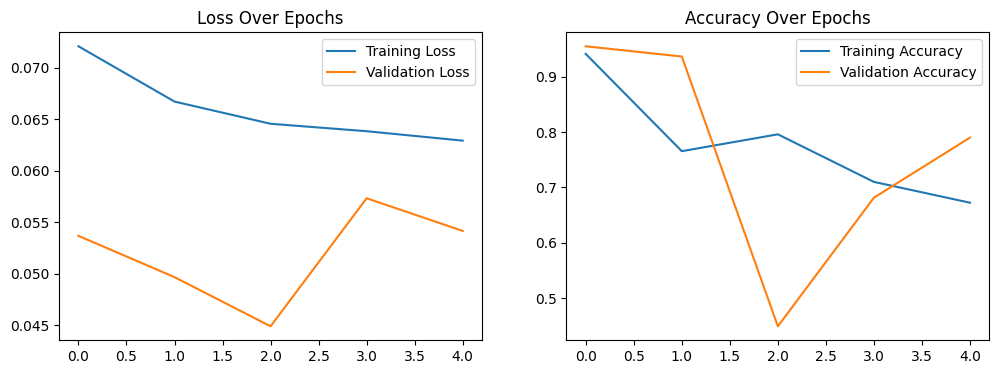

In [16]:
# Визуализация истории обучения
plot_training_history(history)

Хотелось показать написанный код в полной красе, но оказалась сложно, из-за малой мощности стационарного компьютера, возможно для мощного оборудования, задача будет выполнена полностью, но я показываю работоспостобность данного кода. P.S Пришлось уменьшить слои до 64 фильтров, хотя изначально было 512.

В процессе анализа и улучшения кода я сосредоточился на повышении эффективности, гибкости и масштабируемости решения. Изменения включают в себя улучшенную организацию кода, использование многопоточности для ускорения загрузки данных, добавление слоев нормализации и регуляризации для улучшения обучения нейронной сети, а также введение дополнительных коллбэков и метрик для более тонкой настройки и оценки процесса обучения.

Эти улучшения направлены на создание более робастной модели, способной обучаться эффективно и обобщать результаты на новых данных, что особенно важно в задачах сегментации изображений.

Введение в нейронные сети освоины в полной осознанности и мере. Спасибо большое Тимуру за проведенные семинары!